## same as first but now for Af

In [1]:
from PIL import Image
import hdbscan
import time
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
from umap import UMAP
from image_helpers import *
from tsne import image_scatter_plot
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_context("poster")
%pylab inline

import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data, paths, encodings, arrays_rescaled, X = load_encodings('../data/AF_ALL_faces_encodings.pickle')


In [3]:
_, paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = load_encodings('../data/tinder_pics_likes_faces_deduped_firsts_encodings.pickle')
paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = append_new_dataset(paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder, '../data/tinder_pics_2017_deduped_firsts_faces_encodings.pickle')
paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = append_new_dataset(paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder, '../data/tinder_pics_dislikes_faces_firsts_deduped_encodings.pickle')


356 356 356 356
994 994 994 994


In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [5]:
df_ratings = pd.read_csv('../data/SCUT-FBP5500_v2/train_test_files/All_labels.txt', sep=' ', header=None)
df_ratings.columns = ['file_name', 'mean_rating']

In [6]:
look_up_file_to_attractiveness_rating = dict(zip(df_ratings['file_name'], df_ratings['mean_rating']))
paths = [file_path.replace('_face', '').split('/')[-1] for file_path in paths]
colors_dic = [look_up_file_to_attractiveness_rating.get(just_file_name) for just_file_name in paths]
pd.Series(colors_dic).value_counts()

df_file_ratings=pd.DataFrame()
df_file_ratings['ratings']=colors_dic 
df_file_ratings['file_names']=paths 


In [7]:
AF_ALL_labels = df_file_ratings['ratings']

In [8]:
def get_rsquared(y, x):
    '''
    Get RMSE given response variable (y) and predictor set (X)
    USE CASE: helper function for VIF
    '''
    import statsmodels.api as sm

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
 
    return model.rsquared

get_rsquared(AF_ALL_labels, encodings)

0.8048485345893835

In [11]:
def model_cv_score(model, feat_matrix, labels, folds=10, scoring='r2'):
    from sklearn import cross_validation
    '''
    I: persisted model object, feature matrix (numpy or pandas datafram), labels, k-folds, scoring metric
    O: mean of scores over each k-fold (float)
    '''
    return cross_validation.cross_val_score(model, feat_matrix, labels, cv=folds, scoring=scoring)

model_cv_score(LinearRegression(), encodings, AF_ALL_labels)


array([0.70257118, 0.74886254, 0.76711755, 0.72094144, 0.76596147,
       0.82081869, 0.73655473, 0.77199409, 0.77262203, 0.7973108 ])

In [12]:
from sklearn.ensemble import RandomForestRegressor

model_cv_score(RandomForestRegressor(n_estimators=500, n_jobs=-1), encodings, AF_ALL_labels)

array([0.64373908, 0.68517995, 0.67762072, 0.63101733, 0.64973944,
       0.71641008, 0.68640902, 0.70997126, 0.71479512, 0.69848936])

In [15]:
lr = LinearRegression().fit(encodings, AF_ALL_labels)

In [16]:
preds_tinder = lr.predict(encodings_tinder)

In [17]:
num_of_dislikes = len(paths_tinder) - 356

In [18]:
tinder_labels = np.r_[np.ones(356), np.zeros(num_of_dislikes) ]

In [19]:
paths_tinder_ = [path.split('/')[-1].replace('_face.png','').replace('_face.jpg','') for path in paths_tinder]

In [20]:
df = pd.DataFrame (list(zip(paths_tinder_, preds_tinder, tinder_labels)))
df.columns = ['file_name', 'rating', 'like_or_not']
df

,file_name,rating,like_or_not
0,1527363788_Anoushka_0,3.601031,1.0
1,1527366134_Talisha_0,1.400425,1.0
2,1526522411_Bria_1,2.609610,1.0
3,1527365707_Rose_0,3.762781,1.0
4,1525746651_Athena_1,3.189913,1.0
5,1526004657_Samanta_0,2.297899,1.0
6,1527365210_Ayse_0,2.330856,1.0
7,1525746599_Alex_1,2.848996,1.0
8,1526593996_Angelica_0,3.107351,1.0
9,1526837215_Keanu_0,3.101818,1.0


In [33]:
df[df.rating > 4.0 ]

,file_name,rating,like_or_not
19,1526345961_Lani_2,4.339815,1.0
37,1527364596_Melissa_0,4.125600,1.0
39,1526610011_Karina_0,4.260870,1.0
42,1527428841_Olga_0,4.125292,1.0
43,1526522052_Selena_2,4.072375,1.0
58,1526093611_Maddie_0,4.191728,1.0
79,1527363653_Leslie_2,4.122889,1.0
86,1526837566_Rae_1,4.029560,1.0
88,1526004130_Kate_0,4.068952,1.0
92,1526093389_Brianna_1,4.106233,1.0


In [22]:
df[(df.rating > 4.0)  & (df.like_or_not == 0.0)]

,file_name,rating,like_or_not
742,1527364262_Mairin_0,4.127412,0.0


It clearly doesn't work well with africans. I'd have to made a classifier which would lead to a regressors for submodels to CF, AF, africans, etc.

In [34]:
df[(df.rating < 2.0)  & (df.like_or_not == 1.0)]

,file_name,rating,like_or_not
1,1527366134_Talisha_0,1.400425,1.0
154,1490411706_Hanah_1,1.952450,1.0
175,1487213060_Viktoriia_1,1.862349,1.0
178,1488153832_Leah_1,1.886776,1.0
179,1490752651_Melissa_1,1.846413,1.0
230,1487384796_Natalia_1,1.647238,1.0
234,1487300741_Linette_0_negative,1.808134,1.0
289,1490404659_Laura_1,0.999741,1.0
312,1487212172_Diane_1,1.633154,1.0


In [24]:
df[df.rating < 1.5 ]

,file_name,rating,like_or_not
1,1527366134_Talisha_0,1.400425,1.0
289,1490404659_Laura_1,0.999741,1.0
356,1526594652_Kristyn_0,1.499929,0.0
412,1526004446_Italia_0,1.009698,0.0
447,1527363727_Milli_1,1.022944,0.0
449,1527363680_J_1,1.088408,0.0
612,1526346908_Ines_0,1.492149,0.0
621,1526836885_Adesuwa_0,0.928639,0.0
706,1527363732_Belinda_1,1.295744,0.0
720,1526093220_Rachel_0,1.293663,0.0


In [25]:
df[df.like_or_not == 1.0].rating.median()

3.0288437962591956

My likes clearly contain higher rated people but I expected a larger distinction. As it stands it's about 0.5. Could be a product of the classifier I'm using ( Linear Regression )

count    994.000000
mean       2.860639
std        0.576730
min        0.928639
25%        2.487488
50%        2.906671
75%        3.264933
max        4.339815
Name: rating, dtype: float64
skew --  -0.35369661469008146
kurtosis -- 0.19723364301636837


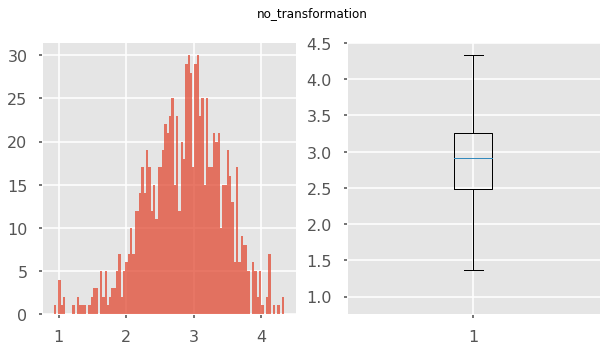

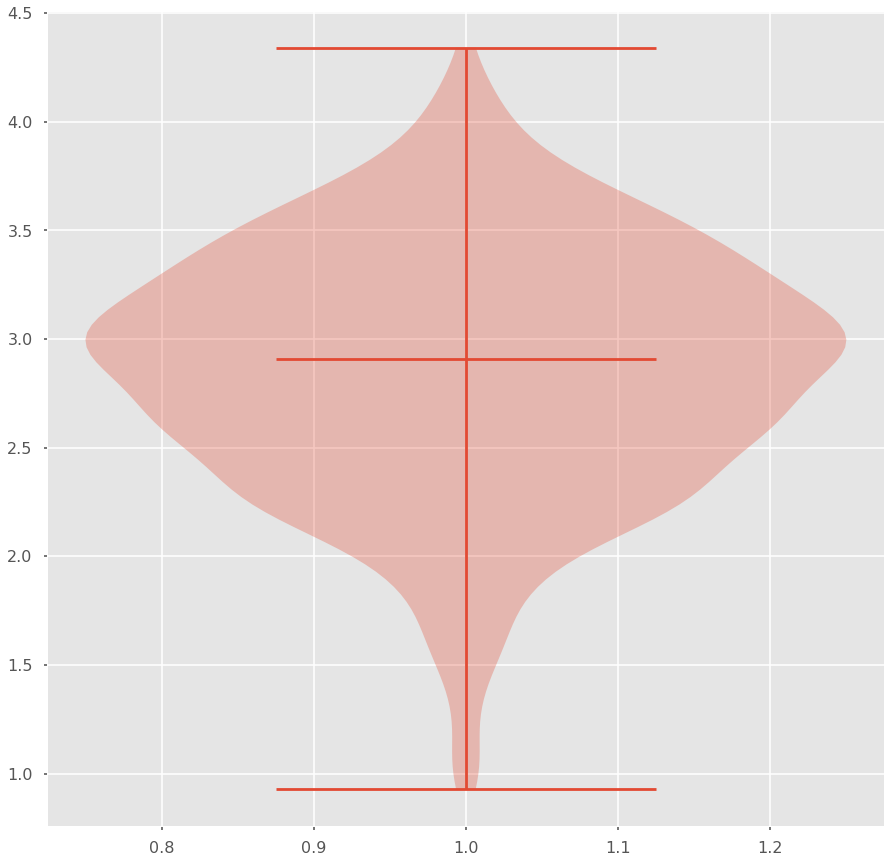

In [26]:
plot_distribution(df.rating)

count    356.000000
mean       3.021059
std        0.547372
min        0.999741
25%        2.631034
50%        3.028844
75%        3.413224
max        4.339815
Name: rating, dtype: float64
skew --  -0.15016864970633806
kurtosis -- 0.0218826382448829


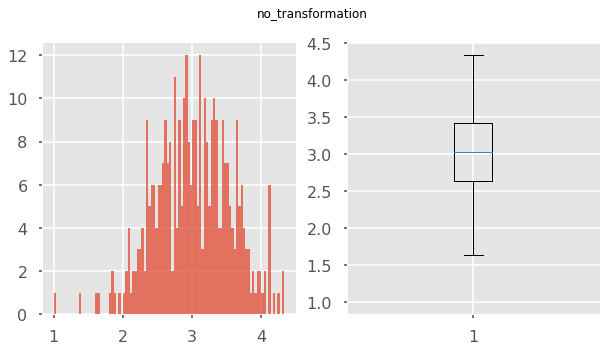

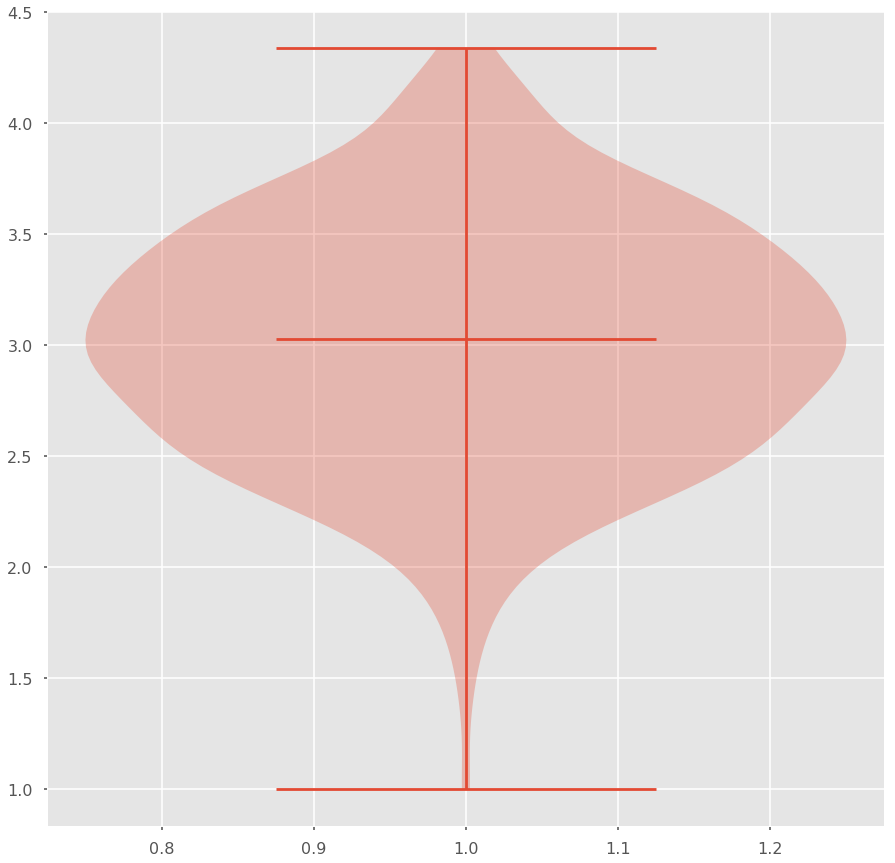

In [27]:
plot_distribution(df[df.like_or_not == 1.0].rating)

count    638.000000
mean       2.771125
std        0.573693
min        0.928639
25%        2.368773
50%        2.847839
75%        3.174329
max        4.127412
Name: rating, dtype: float64
skew --  -0.45357203669016005
kurtosis -- 0.10869193281109357


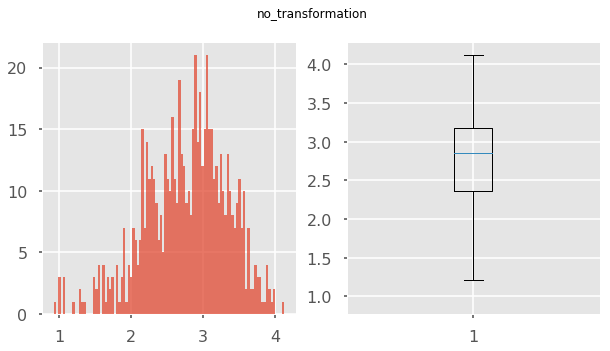

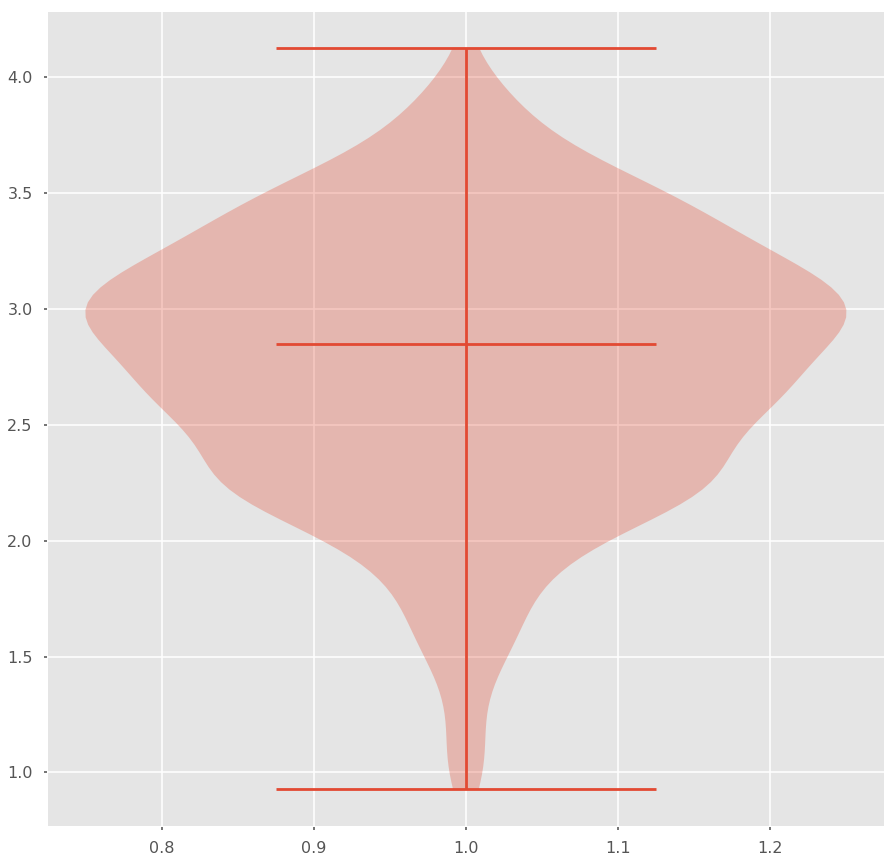

In [28]:
plot_distribution(df[df.like_or_not == 0.0].rating)

## Clearly two seperate populations

The likes: Notice how shifted to the right ( more attractive ) .

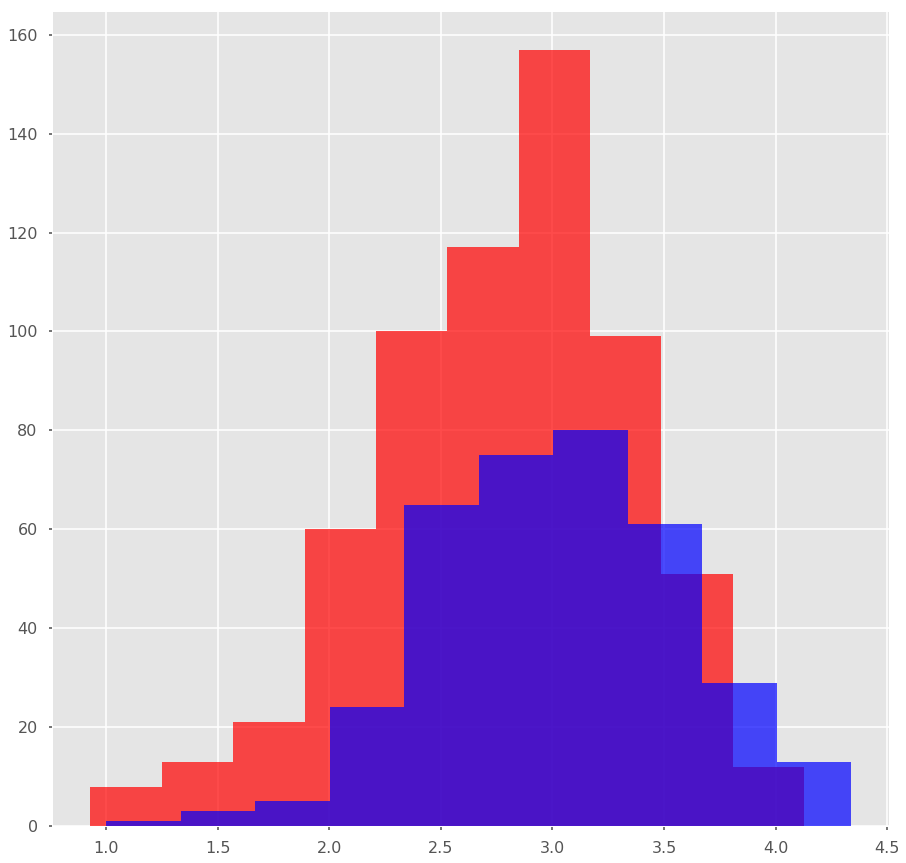

In [29]:
df[df.like_or_not == 0.0].rating.hist(alpha=0.7,bins=10, color='red')
df[df.like_or_not == 1.0].rating.hist(alpha=0.7,bins=10, color='blue')

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a22173e10>],
 'cbars': <matplotlib.collections.LineCollection at 0x1a22178e80>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a22173c88>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1a22178b00>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a22178c50>}

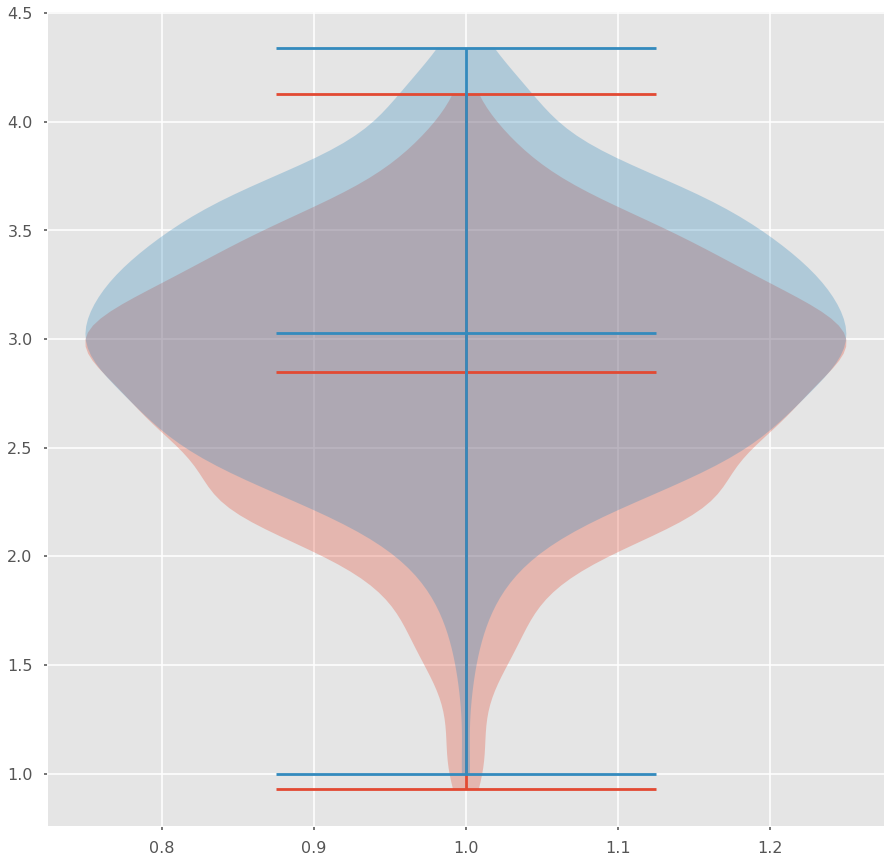

In [30]:
plt.violinplot(
       df[df.like_or_not == 0.0].rating,
       showmeans=False,
       showmedians=True
    )

plt.violinplot(
       df[df.like_or_not == 1.0].rating,
       showmeans=False,
       showmedians=True
    )
